In [1]:
#1. Загрузка библиотек

In [1]:
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import yake
import spacy

morph = MorphAnalyzer()
stop_words = stopwords.words('russian')

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

In [3]:
#2. Загрузка датафрейма и предобработка текста

In [2]:
SecurityLab = pd.read_csv("SecurityLab(8000).csv", encoding = "UTF-8", sep = ",")
full_texts = list(SecurityLab["Text"])

In [5]:
def preprocess(text):
    tokens = wordpunct_tokenize(text)
    lemmatized = [morph.parse(item)[0].normal_form for item in tokens]
    lemmatized = [token for token in lemmatized if token.isalpha()]
    lemmatized = [token for token in lemmatized if len(token) > 1]
    clean_text = [word for word in lemmatized if word not in stop_words]
    return clean_text

In [6]:
preprocessed_texts = [preprocess(text) for text in tqdm(full_texts)]

100%|██████████████████████████████████████████████████████████████████████████████| 8009/8009 [07:16<00:00, 18.35it/s]


In [7]:
#3. Тематическое моделирование предобработанного текста

In [8]:
#превратить список текстов в специальный объект для библиотеки Gensim
gensim_dictionary_for_TM = gensim.corpora.Dictionary(preprocessed_texts)

# удалить из корпуса слова:
# которые встречаются более чем в 10% документах корпуса (no_above=0.1)
# и менее чем в 20 документах (no_below=20)
gensim_dictionary_for_TM.filter_extremes(no_above=0.1, no_below=20)

# сжать словарь после того, как убраны лишние слова
gensim_dictionary_for_TM.compactify()

# посмотреть словарь
print(gensim_dictionary_for_TM)

#преобразовать тексты в bags of words
corpus = [gensim_dictionary_for_TM.doc2bow(text) for text in preprocessed_texts]

Dictionary<4834 unique tokens: ['android', 'apk', 'app', 'apple', 'galaxy']...>


In [9]:
# обучение модели для тематического моделирования
lda = gensim.models.LdaMulticore(corpus,
                                 num_topics = 12, # число тем
                                 id2word=gensim_dictionary_for_TM, 
                                 passes=40, random_state=15)

In [12]:
from gensim.test.utils import datapath

In [13]:
#saving model to disk.

temp_file = datapath("c:/Users/andre/Dev/Keyword-Semantics-Project/lda_model")

lda.save(temp_file)

In [14]:
#loading model from disk

from gensim import models
temp_file = datapath("c:/Users/andre/Dev/Keyword-Semantics-Project/lda_model")
lda = models.ldamodel.LdaModel.load(temp_file)

In [ ]:
#saving model to Google disk.

temp_file = datapath("/content/drive/MyDrive/Colab Notebooks/Magellan-Text-Navigator/data/lda_model")

lda.save(temp_file)

In [ ]:
#loading model from Google disk

from gensim import models
temp_file = datapath("/content/drive/MyDrive/Colab Notebooks/Magellan-Text-Navigator/data/lda_model")
lda = models.ldamodel.LdaModel.load(temp_file)

In [9]:
#4. Визуализация тематического распределения по корпусу

In [15]:
#просмотреть выделенные темы
lda.print_topics(12)

[(0,
  '0.007*"technologies" + 0.007*"pt" + 0.007*"positive" + 0.006*"уровень" + 0.006*"риск" + 0.006*"обнаружение" + 0.005*"облачный" + 0.005*"программный" + 0.005*"предприятие" + 0.005*"исследование"'),
 (1,
  '0.012*"ия" + 0.009*"интеллект" + 0.008*"искусственный" + 0.008*"изображение" + 0.007*"исследование" + 0.007*"модель" + 0.006*"университет" + 0.005*"лицо" + 0.005*"алгоритм" + 0.005*"обучение"'),
 (2,
  '0.025*"криптовалюта" + 0.013*"кошелёк" + 0.011*"процессор" + 0.009*"транзакция" + 0.009*"криптовалютный" + 0.009*"twitter" + 0.009*"сумма" + 0.008*"доллар" + 0.008*"токен" + 0.008*"биржа"'),
 (3,
  '0.010*"facebook" + 0.010*"закон" + 0.007*"право" + 0.007*"рф" + 0.007*"запретить" + 0.006*"минцифра" + 0.006*"контент" + 0.006*"нарушение" + 0.006*"требование" + 0.005*"роскомнадзор"'),
 (4,
  '0.013*"кампания" + 0.010*"фишинговый" + 0.008*"письмо" + 0.008*"браузер" + 0.007*"вредонос" + 0.006*"домен" + 0.006*"загрузка" + 0.006*"полезный" + 0.005*"нагрузка" + 0.005*"троян"'),
 (5,
  

In [16]:
vis = gensimvis.prepare(lda, corpus, gensim_dictionary_for_TM)
pyLDAvis.enable_notebook()
vis

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.172147  0.067730       1        1  12.019236
11     0.147109  0.023140       2        1  11.564351
1      0.009594 -0.100396       3        1  10.072785
9     -0.229235  0.001547       4        1   9.708375
0     -0.105150 -0.158296       5        1   9.415351
3      0.143469 -0.079897       6        1   9.105467
7      0.062894 -0.200954       7        1   7.189397
6      0.176538  0.115153       8        1   6.957318
10    -0.043685  0.090383       9        1   6.890252
5     -0.006393  0.109533      10        1   6.279142
8     -0.037076  0.063544      11        1   5.856491
2      0.054084  0.068513      12        1   4.941834, topic_info=                Term         Freq        Total Category  logprob  loglift
143              cve  2108.000000  2108.000000  Default  30.0000  30.0000
160       вымогатель  1762.000000  1762.000000  Default  29.0000  29.0000
3              apple  1468.000000  1468.000000  Default  28.0000  28.0000
3116  вымогательский  1413.000000  1413.000000  Default  27.0000  27.0000
1190         windows  2048.000000  2048.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
522           проект   158.212606  1312.542525  Topic12  -5.4438   0.8917
247           деньга   143.606281   841.934740  Topic12  -5.5406   1.2388
1493             тыс   144.196508  1233.294934  Topic12  -5.5365   0.8612
894            карта   137.290894   945.929666  Topic12  -5.5856   1.0774
418         цифровой   130.891682  1096.867762  Topic12  -5.6333   0.8816

[789 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4223      2  0.065252       act
4223      6  0.913526       act
4715     10  0.968223  advintel
1282      3  0.974957        ai
1282      4  0.006678        ai
...     ...       ...       ...
423       9  0.009476      язык
423      10  0.077706      язык
423      11  0.003791      язык
1680      3  0.985433  языковой
1242      1  0.977074     ярлык

[3774 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 12, 2, 10, 1, 4, 8, 7, 11, 6, 9, 3])

In [12]:
#5. Наименование тегов пользователем

In [16]:
# функция для форматирования словаря тем
topic_names_dict = {}

def name_topics(number):
    for i in range(number):
        temp = input("введите название темы, input topic name"+str(i))
        topic_names_dict[i] = temp
    return topic_names_dict

In [ ]:
# создание словаря тем
# параметр должен совпадать с количеством тем (num_topics)
name_topics(12)

In [12]:
# сохранённый результат для 12 тем
topic_names_dict={0:"исследования", 1:"разработка", 2:"финансы_и_бизнес", 3:"госрегулирование", 4:"вредоносы", 5:"мошенничества", 6:"законы_и_нарушения", 7:"события_и_мероприятия", 8:"программное_обеспечение", 9:"уязвимости", 10:"утечки", 11:"кибербезопасность"}

In [ ]:
#6. Выделение тегов именованных сущностей

In [13]:
# функция выделения именованных сущностей
entities_dict = {}
def get_ner(text_list):
    nlp = spacy.load("ru_core_news_sm")
    for i in tqdm(range(len(full_texts))):
        doc = nlp(full_texts[i])
        temp=[]
        for ent in doc.ents:
            temp.append(ent.text)
            entities_dict[i]=temp
    return entities_dict

In [ ]:
# запуск функции выделения именованных сущностей

In [14]:
get_ner(full_texts)

C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

{0: ['Apple',
  'Google',
  'Европе',
  'Атлантики',
  'Белого дома',
  'Apple',
  'Google',
  'Национальное управление телекоммуникаций и информации',
  'Министерства торговли (NTIA)',
  'Apple',
  'Apple',
  'Apple',
  'Apple',
  'App Store',
  'Европы',
  'США',
  'Apple',
  'Apple',
  'Samsung',
  'Huawei App Gallery',
  'Xiaomi GetApps',
  'RuStore',
  'Купертино',
  'Южная Корея',
  'Нидерланды',
  'Apple',
  'Google',
  'Евросоюз',
  'Apple'],
 1: ['Lazarus Group',
  'Zimbra',
  'WithSecure',
  'No Pineapple',
  'Zimbra',
  'WithSecure',
  'Dtrack',
  'GREASE',
  'GREASE',
  'Северной Кореей',
  'Kimsuky',
  'Dtrack',
  'Maui',
  'C2-сервер',
  'Cisco Talos',
  'Lazarus Group',
  'Северной Кореей',
  'КНДР'],
 2: ['Лаборатории Касперского', 'Лаборатория Касперского'],
 3: ['Евросоюз',
  'ЕС',
  'Норвегия',
  'Исландия',
  'Еврокомиссии',
  'Дидье Рейндерса',
  'Дидье',
  'Еврокомиссия',
  'Европейский совет по защите данных (EDPB)',
  'Евросоюзе'],
 4: ['LockBit',
  'LockBit',
 

In [17]:
# функция нормализации именованных сущностей
def preprocess_ent(entities_dict):
    lemmatized = [morph.parse(item)[0].normal_form for item in entities_dict]
    lemmatized = [token for token in lemmatized if token.isalpha()]
    lemmatized = [token for token in lemmatized if len(token) > 3]
    return lemmatized

In [18]:
# создание словаря уникальных токенов с помощью множества
unified_dict = {}
for(i) in range(len(entities_dict.values())):  
    try:
        a = list(set(entities_dict[i]))
        unified_dict[i] = a
    except:
        unified_dict[i] = []

# нормализация токенов и создание словаря нормализованных токенов
normalized_dict = {}
for i in range(len(unified_dict.values())):
    normalized_dict[i] = list(set(preprocess_ent(unified_dict[i])))

# создание счетчика токенов 
counter_dict = {}
for i in normalized_dict.values():
    for a in i:
        counter_dict[a] = counter_dict.get(a, 0) + 1

# токены в словаре фильтруются по частотным показателям
clear_list = []
for i in counter_dict.items():
    if i[1] >= (0.001*len(full_texts)):
        clear_list.append(i[0])

# токены именованных сущностей в готовом виде записываются в словарь        
name_tags={}
for k, v  in normalized_dict.items():
    temp_list = []
    for i in v:
        if i in clear_list:
            temp_list.append(i.capitalize())
    name_tags[k] = ", ".join(temp_list)

In [19]:
#6. Извлечение ключевых слов

In [20]:
# создание объекта Yake
extractor = yake.KeywordExtractor(
lan= "ru",
n = 1,
dedupLim = 0.3,
top = 10
)

In [21]:
# создание функции выделения ключевых слов
raw_keywords = []
def extract_kw(list):
    for text in list:
        yakelist = []
        for word in extractor.extract_keywords(text):
            yakelist.append(word[0])
        raw_keywords.append(yakelist)
    return raw_keywords

In [22]:
# создание функции нормализации ключевых слов
keywords = []
def preprocess_kw(list):
    for sublist in list:
        lemmatized = []
        lemmatized = [morph.parse(item)[0].normal_form for item in sublist]
        lemmatized = [token for token in lemmatized if token.isalpha()]
        lemmatized = [token for token in lemmatized if len(token) > 3]
        keywords.append(", ".join(lemmatized))
    return keywords

In [23]:
# запуск функции выделения ключевых слов
raw_kw = extract_kw(full_texts)

In [24]:
#запуск функции нормализации ключевых слов
keywords = preprocess_kw(raw_kw)

In [34]:
#7. Назначение новых тегов и сохранение корпуса

In [25]:
# выделение трех наиболее важных тем для каждого текста в корпусе и запись их в словарь
topic_dict={}
for a in range(len(preprocessed_texts)):
    temp_dict = zip([b[1] for b in lda.get_document_topics(corpus[a])],[b[0] for b in lda.get_document_topics(corpus[a])])
    top = sorted(temp_dict, reverse = True)[:3]
    top_topics = []
    for c in top:
        top_topics.append(topic_names_dict[c[1]])
    topic_dict[a]=top_topics

In [ ]:
#разделение тем по колонкам в таблице

old_tags = list(SecurityLab["Tags"])
original_tags = []
for i in old_tags:
    a = i.translate(str.maketrans("","", "\'\"()"))
    original_tags.append(a)
    
dates = list(SecurityLab["Date"])
texts = list(SecurityLab["Text"])
titles = list(SecurityLab["Title"])
subtitles = list(SecurityLab["Subtitle"])
news_links = list(SecurityLab["Unnamed: 0"])
ent_tags = list([i for i in name_tags.values()])
topic_tags = list([i for i in topic_dict.values()])

topic_tag_1 = []
topic_tag_2 = []
topic_tag_3 = []

for i in range(len(topic_tags)):
    if len(topic_tags[i]) == 1:
        topic_tag_1.append(topic_tags[i][0])
        topic_tag_2.append("")
        topic_tag_3.append("")
    elif len(topic_tags[i]) == 2:
        topic_tag_1.append(topic_tags[i][0])
        topic_tag_2.append(topic_tags[i][1])
        topic_tag_3.append("")
    elif len(topic_tags[i]) == 3:
        topic_tag_1.append(topic_tags[i][0])
        topic_tag_2.append(topic_tags[i][1])
        topic_tag_3.append(topic_tags[i][2])

In [ ]:
data_list = dates, titles, subtitles, original_tags, topic_tag_1, topic_tag_2, topic_tag_3, ent_tags, keywords, texts
SecurityLab_df = pd.DataFrame(data_list, columns = news_links).T
SecurityLab_df = SecurityLab_df.rename(columns={0: "Date", 1:"Title", 2:"Subtitle", 3:"Original_tags", 4:"Topic_tag_1", 5:"Topic_tag_2", 6:"Topic_tag_3", 7:"Name_tags", 8:"Keywords", 9:"Text"})
SecurityLab_df.to_csv("Secure_df_processed.csv", encoding="utf-8")

In [41]:
#8. Оценка результатов работы модели LDA с помощью параметра Coherence score по метрике c_v

In [27]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=preprocessed_texts,
                                     dictionary=gensim_dictionary_for_TM,
                                     coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
 
print("\nCoherence Score: ", coherence_lda)


# оценка качества тематического моделирования по отношению к количеству тем, метрика c_v


Coherence Score:  0.5973521850569755


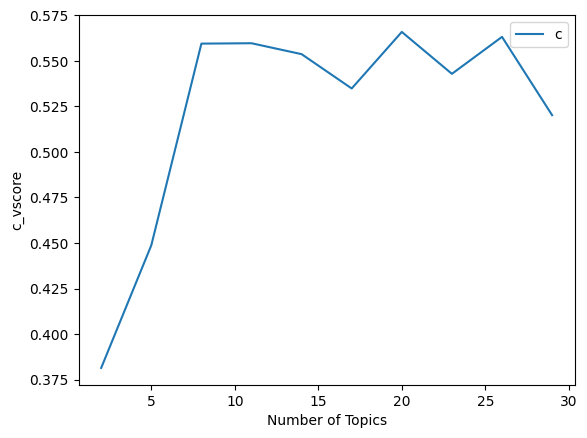

In [94]:
def coherence_score(dictionary, corpus, texts, max, start=2, step=3,
                    measure="c_uci"):

    coherence_values = []
    for num_topics in range(start, max, step):
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                           passes=10, num_topics=num_topics, 
                                           random_state=15)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                        dictionary=dictionary, 
                                        coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, max, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel(measure + "score")
    plt.legend(("coherence_score"), loc='best')
    plt.show()

coherence_score(dictionary=gensim_dictionary_for_TM, corpus=corpus, texts=preprocessed_texts, start=2, max=30, step=3, measure="c_v")